In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from cmcrameri import cm

In [2]:
directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s/"
#file = "HFFZ_fullycp-receiver-00039-00031.dat"
#file = "HFFZ_fullycp-receiver-00116-00014.dat"
file = "HFFZ_fullycp-receiver-00164-00011.dat"

In [3]:
column_names = ["Time","xx","yy","zz","xy","yz","xz","u","v","w"]

In [4]:
df = pd.read_csv(directory+file, skiprows=5, sep='\s+', names=column_names)
df.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
df.head()

,Time,u,v,w
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00
3,0.3,1.658069e-132,5.827383e-132,-1.062238e-131
4,0.4,6.498836e-97,2.962924e-96,-1.470703e-96


In [5]:
coords = pd.read_csv(directory+file, nrows=3, skiprows=2, header=None, sep="\s+") #names=["x1", "x2", "x3"]
x1 = coords[2][0]
x2 = coords[2][1]
x3 = coords[2][2]

In [6]:
df["x1"]=x1
df["x2"]=x2
df["x3"]=x3
df.head()

,Time,u,v,w,x1,x2,x3
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,630893.0,7357970.0,0.0
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00,630893.0,7357970.0,0.0
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00,630893.0,7357970.0,0.0
3,0.3,1.658069e-132,5.827383e-132,-1.062238e-131,630893.0,7357970.0,0.0
4,0.4,6.498836e-97,2.962924e-96,-1.470703e-96,630893.0,7357970.0,0.0


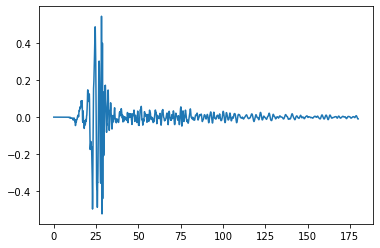

In [7]:
plt.plot(df.Time,df.w)

In [9]:
# need to adjust time due to floating point errors/ rounding
df["Time"] = np.linspace(0, 179.9, 1800)
df.loc[df['Time'] == 40.0]

,Time,u,v,w,x1,x2,x3
400,40.0,-0.000139,-0.000992,0.040711,630893.0,7357970.0,0.0


# Stack

In [10]:
files = glob.glob(os.path.join(directory, "HFFZ_fullycp-receiver*.dat"))

In [31]:
for f in files:
    frame = pd.read_csv(f, skiprows=5, sep='\s+', names=column_names)
    frame.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    frame["x1"]=x1
    frame["x2"]=x2
    frame["x3"]=x3
    if (files[0]==f):
        stack = frame.loc[df['Time'] == 20.0]
    else:
        stack = pd.concat([stack, frame.loc[df['Time'] == 20.0]])

In [32]:
stack.sort_values(by="x1", inplace=True)

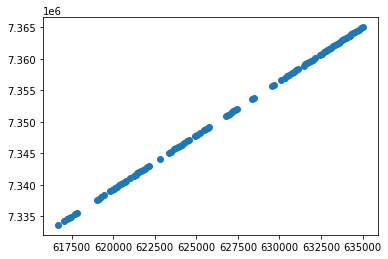

In [33]:
plt.plot(stack.x1,stack.x2,'o')

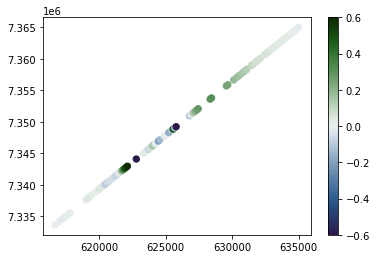

In [34]:
sc = plt.scatter(stack.x1,stack.x2, c=stack.w, vmin=-0.6, vmax=0.6, s=40, cmap=cm.cork)
plt.colorbar(sc)
plt.show()